In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

import re
from IPython import display
from transformers import BertTokenizer, TFBertModel

C:\Users\HMILAB\anaconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from tensorflow.keras.layers import Input, Embedding, LSTM, \
Conv2D, Conv2DTranspose, Dense, Flatten, BatchNormalization
from tensorflow.python.keras import Sequential

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
tf.config.run_functions_eagerly(True)
tf.compat.v1.enable_eager_execution()

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Pick 5 descriptions from testing data and generate 5 images with different noise z respectively.

[' this white and purple flower has fragile petals and soft stamens']
[' this flower has four large wide pink petals with white centers and vein like markings']
[' a flower with broad white and pink ribbed petals and yellow stamen']
[' one prominet pistil with alarger stigam and many stamens with anthers']
[' leaves are green in color petals are light pink in color']


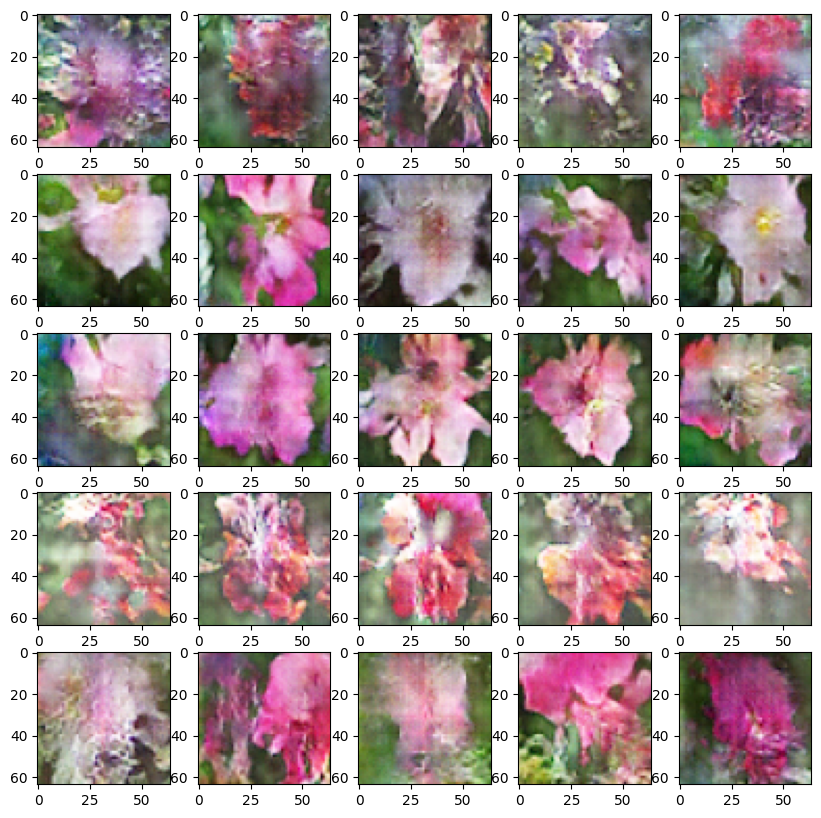

In [69]:
idx = [23, 216, 224, 413, 713]
fig = plt.figure(figsize=(10, 10))
hparas['BATCH_SIZE'] = 1
count = 1
for captions, idx in testing_dataset:
    print(id2sentence(id2word_dict, captions))
    for j in range(5):
        sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(hparas['BATCH_SIZE'], hparas['Z_DIM'])).astype(np.float32)
        fake_image = test_step(captions, sample_seed)
        for i in range(hparas['BATCH_SIZE']):
            img = np.array(fake_image[i])
#             print(img.max(), img.min())
            img = (img-img.min()) * (1/((img.max()-img.min())))
            plt.subplot(5, 5, count)
            plt.imshow(img)
        count+=1
    if(count==26):
        break
        
plt.show()

## Preprocess Text
Since dealing with raw string is inefficient, we have done some data preprocessing for you:

* Delete text over **MAX_SEQ_LENGTH (20)**.
* Delete all puntuation in the texts.
* Encode each vocabulary in **dictionary/vocab.npy**.
* Represent texts by a sequence of integer IDs.
* Replace rare words by **\<RARE>** token to reduce vocabulary size for more efficient training.
* Add padding as **\<PAD>** to each text to make sure all of them have equal length to **MAX_SEQ_LENGTH (20)**.
It is worth knowing that there is no necessary to append **\<ST>** and **\<ED>** to each text because we don't need to generate any sequence in this task.

To make sure correctness of encoding of the original text, we can decode sequence vocabulary IDs by looking up the vocabulary dictionary:

* dictionary/word2Id.npy is a numpy array mapping word to id.
* dictionary/id2Word.npy is a numpy array mapping id back to word.

In [6]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [7]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    
    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l
    
    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]

    return line

text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))

the flower shown has yellow anther red pistil and bright red petals.
['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427']


## Dataset
For training, the following files are in dataset folder:

* **./dataset/text2ImgData.pkl** is a pandas dataframe with attribute 'Captions' and 'ImagePath'.
    * 'Captions' : A list of text id list contain 1 to 10 captions.
    * 'ImagePath': Image path that store paired image.
* **./102flowers/** is the directory containing all training images.
* **./dataset/testData.pkl** is a pandas a dataframe with attribute 'ID' and 'Captions', which contains testing data.

In [8]:
data_path = './dataset'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))

There are 7370 image in training data


In [9]:
df.head(5)

,Captions,ImagePath
ID,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg


## Create Dataset by Dataset API

In [77]:
BATCH_SIZE = 64
hparas = {
    'MAX_SEQ_LENGTH': 20,                     # maximum sequence length
    'EMBED_DIM': 256,                         # word embedding dimension
    'VOCAB_SIZE': len(word2Id_dict),          # size of dictionary of captions
    'RNN_HIDDEN_SIZE': 128,                   # number of RNN neurons
    'Z_DIM': 512,                             # random noise z dimension
    'DENSE_DIM': 128,                         # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': BATCH_SIZE,
    'LR': 0.0002,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 10000,
    'N_SAMPLE': num_training_sample,          # size of training data
    'CHECKPOINTS_DIR': './checkpoints/demo',  # checkpoint path
    'PRINT_FREQ': 1                          # printing frequency of loss
}

In [11]:
# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

def training_data_generator(caption, image_path):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    
    if(random.random() < 0.5):
        img = tf.image.stateless_random_crop(img, (48, 48, 3), seed = (0,1))
        img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    
    caption = tf.cast(caption, tf.int32)

    return img, caption

def dataset_generator(filenames, batch_size, data_generator):
    # load the training data into two NumPy arrays
    df = pd.read_pickle(filenames)
    captions = df['Captions'].values
    caption = []
    # each image has 1 to 10 corresponding captions
    # we choose one of them randomly for training
    for i in range(len(captions)):
        caption.append(random.choice(captions[i]))
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    image_path = df['ImagePath'].values
    
    # assume that each row of `features` corresponds to the same row as `labels`.
    assert caption.shape[0] == image_path.shape[0]
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, image_path))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(caption)).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [12]:
dataset = dataset_generator(data_path + '/text2ImgData.pkl', hparas["BATCH_SIZE"], training_data_generator)

# Text Encoder

在助教提供的template中是使用GNU，而我們則是選擇採用BERT這個pretrained model來當作我們的text encoder，用來取得embedding。

In [13]:
def id2sentence(id2word_dict, id_sent):
    batch_sentence = []
    for j in range(id_sent.shape[0]):
        sent=""
        for i in range(len(id_sent[j])):
            if id2word_dict[str(int(id_sent[j][i].numpy()))]=="<PAD>":
                continue
            sent=sent+" "+(id2word_dict[str(int(id_sent[j][i].numpy()))])
        
        batch_sentence.append(sent)
    return batch_sentence

In [14]:
bert_tokenizer = BertTokenizer.from_pretrained(
    'bert-large-uncased', 
    do_lower_case=False,
    do_basic_tokenize=False
)
bert_model = TFBertModel.from_pretrained('bert-large-uncased')

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [15]:
def text_encoder(caption):
    try:
        string_list = id2sentence(id2word_dict, caption)
        bert_inputs = bert_tokenizer(string_list, return_tensors="tf", padding='max_length',max_length=30)
        bert_outputs = bert_model(bert_inputs)
        caption_embedding = bert_outputs.last_hidden_state[:,0]
    except(ValueError):
        print(string_list)
    return tf.convert_to_tensor(caption_embedding.numpy().tolist())

In [16]:
# for idx, (image, caption) in enumerate(dataset):
#     image=np.array(image)
#     plt.imshow(image[0])
#     plt.show()
#     text_embed = text_encoder(caption)
#     print(text_embed[0].shape)
#     break

# Generator

我們的架構如下：
1. 先將text embedding flatten並傳入一層dense layer，然後和noise concate起來後再傳入一層dense layer，normalize並reshape後產生第一個output x0。
2. 之後，將x0傳入三層convolutional layer，中間穿插batch normalization，產生第二個output x1。
3. 接著，將x0、x1相加，經過一層convolutional transpose layer並normalizaiton，產生第三個output x2。
4. 把x2傳入三層convolutional layer，中間穿插batch normalization，產生第四個output x。
5. 把x、x2相加，經過兩層convolutional transpose layer並穿插normalizaiton，產生最終的logits。
6. 最後用tanh產生最終output。

此外，在上述架構中，有用到activation function的部份我們全部是採用relu，並將relu的alpha值設為0.2。

In [17]:
NUM_EPOCHS = 10000
LEAKY_ALPHA = 0.2
def my_leaky_relu(tensor):
    return tf.nn.leaky_relu(tensor, alpha=LEAKY_ALPHA)

In [18]:
class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        self.flatten = Flatten()
#         self.d1 = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
#         self.d2 = tf.keras.layers.Dense(64*64*3)

        self.d1 = Dense(self.hparas['DENSE_DIM'], activation=my_leaky_relu)
        self.d2 = Dense(128*8*4*4)
        self.BN0 = BatchNormalization()
        
        self.conv1 = Conv2D(
            filters=256,
            kernel_size=[1, 1],
            strides=[1, 1],
            padding="valid",
            activation=my_leaky_relu
        )
        self.BN1 = BatchNormalization()
        
        self.conv2 = Conv2D(
            filters=256,
            kernel_size=[3, 3],
            strides=[1, 1],
            padding="same",
            activation=my_leaky_relu
        )
        self.BN2 = BatchNormalization()
        
        self.conv3 = Conv2D(
            filters=128*8,
            kernel_size=[3, 3],
            strides=[1, 1],
            padding="same"
        )
        
        self.BN3 = BatchNormalization()
        
        self.conv4_T = Conv2DTranspose(
            filters=128*4,
            kernel_size=[3, 3],
            strides=[2, 2],
            padding="same"
        )
        self.BN4 = BatchNormalization()
        
        self.conv5 = Conv2D(
            filters=128,
            kernel_size=[1, 1],
            strides=[1, 1],
            padding="valid",
            activation=my_leaky_relu
        )
        self.BN5 = BatchNormalization()
        
        self.conv6 = Conv2D(
            filters=128,
            kernel_size=[3, 3],
            strides=[1, 1],
            padding="same",
            activation=my_leaky_relu
        )
        self.BN6 = BatchNormalization()
        
        
        self.conv7 = Conv2D(
            filters=128*4,
            kernel_size=[3, 3],
            strides=[1, 1],
            padding="same"
        )
        self.BN7 = BatchNormalization()
        
        self.conv8_T = Conv2DTranspose(
            filters=128*2,
            kernel_size=[3, 3],
            strides=[2, 2],
            padding="same",
            activation=my_leaky_relu
        )
        self.BN8 = BatchNormalization()
        
        self.conv9_T = Conv2DTranspose(
            filters=128,
            kernel_size=[3, 3],
            strides=[2, 2],
            padding="same",
            activation=my_leaky_relu
        )
        self.BN9 = BatchNormalization()
    
        self.out = Conv2DTranspose(
            filters=3,
            kernel_size=[3, 3],
            strides=[2, 2],
            padding="same",
#             activation=tf.tanh
        )
        
        
    def call(self, text, noise_z):

        text = self.flatten(text)
        x0 = self.d1(text)
        x0 = tf.concat([noise_z, x0], axis=1)
        x0 = self.d2(x0)
        x0 = self.BN0(x0)
        x0 = tf.reshape(x0, shape=[-1, 4, 4, 128*8])
        
        x1 = self.conv1(x0)
        x1 = self.BN1(x1)
        x1 = self.conv2(x1)
        x1 = self.BN2(x1)
        x1 = self.conv3(x1)
        x1 = self.BN3(x1)
        
        x2 = tf.add(x0, x1)
        x2 = self.conv4_T(x2)
        x2 = self.BN4(x2)
        x = self.conv5(x2)
        x = self.BN5(x)
        x = self.conv6(x)
        x = self.BN6(x)
        x = self.conv7(x)
        x = self.BN7(x)
        
        x3 = tf.add(x2, x)
        x3 = self.conv8_T(x3)
        x3 = self.BN8(x3)
        x3 = self.conv9_T(x3)
        x3 = self.BN9(x3)
        
        logits = self.out(x3)
        output = tf.nn.tanh(logits)


        return logits, output

# Discriminator

我們的架構如下:

1. 先單獨處理圖片:
    * 把圖片經過一個convolutional layer後，再經過三次convolutional layer和batch normalization的穿插，得到第一個output x0。
    * 將x0再經過三次convolutional layer和batch normalization的穿插，得到output x。
    * 把x和x0相加，得到output x1。
2. 加入text:
    * 將text經過預處理(tile、expand_dim)，然後和x1 concate起來。
    * 經過一層convolutional layer和一層normalizaiton，產生最終的logits。
3. 最後用tanh產生最終output。

In [19]:
class Discriminator(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        self.flatten = Flatten()

        
        self.conv1 = Conv2D(
            filters=64,
            kernel_size=[4, 4],
            strides=[2, 2],
            padding="same",
            activation=my_leaky_relu
        )
        
        self.conv2 = Conv2D(
            filters=128,
            kernel_size=[4, 4],
            strides=[2, 2],
            padding="same",
            activation=my_leaky_relu
        )
        
        self.BN2 = BatchNormalization()
        
        self.conv3 = Conv2D(
            filters=256,
            kernel_size=[4, 4],
            strides=[2, 2],
            padding="same",
            activation=my_leaky_relu
        )
        
        self.BN3 = BatchNormalization()
        
        self.conv4 = Conv2D(
            filters=512,
            kernel_size=[4, 4],
            strides=[2, 2],
            padding="same",
            activation=None
        )
        self.BN4 = BatchNormalization()
        
        self.conv5 = Conv2D(
            filters=128,
            kernel_size=[1, 1],
            strides=[1, 1],
            padding="valid",
            activation=my_leaky_relu
        )
        self.BN5 = BatchNormalization()
        
        self.conv6 = Conv2D(
            filters=128,
            kernel_size=[3, 3],
            strides=[1, 1],
            padding="same",
            activation=my_leaky_relu
        )
        self.BN6 = BatchNormalization()
        
        self.conv7 = Conv2D(
            filters=512,
            kernel_size=[3, 3],
            strides=[1, 1],
            padding="same"
        )
        self.BN7 = BatchNormalization()
        
        
        
        #text
        
        self.d1 = Dense(self.hparas['DENSE_DIM'], activation=my_leaky_relu)
        
        self.conv8 = Conv2D(
            filters=512,
            kernel_size=[1, 1],
            strides=[1, 1],
            padding="valid",
            activation=my_leaky_relu
        )
        self.BN8 = BatchNormalization()
        
        self.out = Conv2D(
            filters=1,
            kernel_size=[4, 4],
            strides=[4, 4],
            padding="valid"
        )
    
    def call(self, img, text):
        
        x0 = self.conv1(img)
        x0 = self.conv2(x0)
        x0 = self.BN2(x0)
        x0 = self.conv3(x0)
        x0 = self.BN3(x0)
        x0 = self.conv4(x0)
        x0 = self.BN4(x0)
        
        x = self.conv5(x0)
        x = self.BN5(x)
        x = self.conv6(x)
        x = self.BN6(x)
        x = self.conv7(x)
        x = self.BN7(x)
        
        x1 = tf.add(x0, x)
        
        #text
        x2 = self.d1(text)
        x2 = tf.expand_dims(x2, axis=1)
        x2 = tf.expand_dims(x2, axis=1)
        
        x2 = tf.tile(x2, multiples=[1, 4, 4, 1])
        x3 = tf.concat(values=[x1, x2], axis=3)
        x3 = self.conv8(x3)
        x3 = self.BN8(x3)
        
        logits = self.out(x3)
        output = tf.nn.sigmoid(logits)
        
        return logits, output

In [20]:
generator = Generator(hparas)
discriminator = Discriminator(hparas)

In [21]:
for idx, (image, caption) in enumerate(dataset):   
    text_embed = text_encoder(caption)   
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
    _, fake_image = generator(text_embed, noise)
    fake_logits, fake_output = discriminator(fake_image, text_embed)  
    break

In [22]:
generator.load_weights("models/W_generator_bert.h5")
discriminator.load_weights("models/W_discriminator_bert.h5")

Lo

In [24]:
optimizer_g = tf.keras.optimizers.Adam(learning_rate = 1e-4, beta_1=hparas['BETA_1'])
optimizer_d = tf.keras.optimizers.Adam(learning_rate = 3e-4, beta_1=hparas['BETA_1'])

In [25]:
LAMBDA = 10

@tf.function
def WGTrain(real_image, caption, noise_decay):
    #c1: true image
#     z = tf.random.normal(BZ)
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)
    
    with tf.GradientTape() as tpg, tf.GradientTape() as inter_tpg:
        text_embed = text_encoder(caption)
        
        #c0: fake image
        _, fake_image = generator(text_embed, noise)
        alpha = tf.random.uniform([hparas['BATCH_SIZE'], 1, 1, 1])
        interpolates = alpha * fake_image + (1.0 - alpha) * real_image
        
        fake_image = fake_image + noise_decay * tf.random.normal(fake_image.shape)
        real_image = real_image + noise_decay * tf.random.normal(real_image.shape)
        interpolates = interpolates + noise_decay * tf.random.normal(interpolates.shape)
        
        real_logits, real_output = discriminator(real_image, text_embed)
        fake_logits, fake_output = discriminator(fake_image, text_embed)
        mismatch_logits, mismatch_output = discriminator(interpolates, text_embed)

        gradient_penalty = inter_tpg.gradient(mismatch_logits,interpolates)
        gradient_penalty = tf.sqrt(tf.reduce_sum(tf.math.square(gradient_penalty),axis=[1,2,3]))
        loss = fake_logits - real_logits + 10. * tf.math.square((gradient_penalty - 1.))
        ld = tf.reduce_mean(loss)
        lg = - tf.reduce_mean(fake_logits)

    gradient_g = tpg.gradient(lg, generator.trainable_variables)

    optimizer_g.apply_gradients(zip(gradient_g, generator.trainable_variables))
    
    return lg, ld

@tf.function
def WDTrain(real_image, caption, noise_decay):
    #c1: true image
#     z = tf.random.normal(BZ)
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']], mean=0.0, stddev=1.0)

    with tf.GradientTape() as tpd, tf.GradientTape() as inter_tpg:
        text_embed = text_encoder(caption)
        
        
        #c0: fake image
        _, fake_image = generator(text_embed, noise)
        alpha = tf.random.uniform([hparas['BATCH_SIZE'], 1, 1, 1])
        interpolates = alpha * fake_image + (1.0 - alpha) * real_image
        
        fake_image = fake_image + noise_decay * tf.random.normal(fake_image.shape)
        real_image = real_image + noise_decay * tf.random.normal(real_image.shape)
        interpolates = interpolates + noise_decay * tf.random.normal(interpolates.shape)
        
        real_logits, real_output = discriminator(real_image, text_embed)
        fake_logits, fake_output = discriminator(fake_image, text_embed)
        mismatch_logits, mismatch_output = discriminator(interpolates, text_embed)

        gradient_penalty = inter_tpg.gradient(mismatch_logits,interpolates)
        gradient_penalty = tf.sqrt(tf.reduce_sum(tf.math.square(gradient_penalty),axis=[1,2,3]))
        loss = fake_logits - real_logits + 10. * tf.math.square((gradient_penalty - 1.))
        ld = tf.reduce_mean(loss)
        lg = - tf.reduce_mean(fake_logits)


    gradient_d = tpd.gradient(ld, discriminator.trainable_variables)

    optimizer_d.apply_gradients(zip(gradient_d, discriminator.trainable_variables))
   
    return lg, ld

In [26]:
@tf.function
def test_step(caption, noise):
    text_embed = text_encoder(caption)
    _, fake_image = generator(text_embed, noise)
    return fake_image

### Visualiztion
During training, we can visualize the generated image to evaluate the quality of generator. The followings are some functions helping visualization.

In [27]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    # getting the pixel values between [0, 1] to save it
    return plt.imsave(path, merge(images, size)*0.5 + 0.5)

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

In [28]:
def sample_generator(caption, batch_size):
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    dataset = tf.data.Dataset.from_tensor_slices(caption)
    dataset = dataset.batch(batch_size)
    return dataset

In [29]:
ni = int(np.ceil(np.sqrt(hparas['BATCH_SIZE'])))
sample_size = hparas['BATCH_SIZE']
sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
sample_sentence = ["the flower shown has yellow anther red pistil and bright red petals."] * int(sample_size/ni) + \
                  ["this flower has petals that are yellow, white and purple and has dark lines"] * int(sample_size/ni) + \
                  ["the petals on this flower are white with a yellow center"] * int(sample_size/ni) + \
                  ["this flower has a lot of small round pink petals."] * int(sample_size/ni) + \
                  ["this flower is orange in color, and has petals that are ruffled and rounded."] * int(sample_size/ni) + \
                  ["the flower has yellow petals and the center of it is brown."] * int(sample_size/ni) + \
                  ["flower with white long white petals and very long purple stamen."] * int(sample_size/ni) +\
                  ["these white flowers have petals that start off white in color and end in a white towards the tips."] * int(sample_size/ni)

for i, sent in enumerate(sample_sentence):
    sample_sentence[i] = sent2IdList(sent)
print(len(sample_sentence))
sample_sentence = sample_generator(sample_sentence, hparas['BATCH_SIZE'])

8


# Training

之前的lab在練習GAN時，是每5個discriminator的train之後接上1個generator的train，但這次助教的template中卻沒有這種比例調整。

我們這次採用的則是每2個discriminator的train之後接上1個generator的train。

In [30]:
WTrain = (
    WDTrain,
    WDTrain,
#     WDTrain,
#     WDTrain,
#     WDTrain,
    WGTrain
)

WCritic = len(WTrain)

In [31]:
def train(dataset, epochs):
    # hidden state of RNN
    steps_per_epoch = int(hparas['N_SAMPLE']/hparas['BATCH_SIZE'])
    ctr = 0
    for epoch in range(hparas['N_EPOCH']):
        g_total_loss = 0
        d_total_loss = 0
        start = time.time()
        
#         if epoch < 200:
#             noise_decay = 1.0 / float(epoch+1)
#         else:
        noise_decay = 0.0
        
        for step, (image, caption) in enumerate(dataset):
            g_loss, d_loss = WTrain[ctr](image, caption, noise_decay)
            ctr += 1
            g_total_loss += g_loss
            d_total_loss += d_loss
            if ctr == WCritic : 
                ctr = 0
            
        time_tuple = time.localtime()
        time_string = time.strftime("%m/%d/%Y, %H:%M:%S", time_tuple)
            
        print("Epoch {}, gen_loss: {:.4f}, disc_loss: {:.4f}".format(epoch+1,
                                                                     g_total_loss/steps_per_epoch,
                                                                     d_total_loss/steps_per_epoch))
        print('Time for epoch {} is {:.4f} sec'.format(epoch+1, time.time()-start))
        
        generator.save_weights("models/W_generator_bert.h5")
        discriminator.save_weights("models/W_discriminator_bert.h5")
        
        
        # visualization
        if (epoch + 1) % hparas['PRINT_FREQ'] == 0:
            for caption in sample_sentence:
                fake_image = test_step(caption, sample_seed)
            save_images(fake_image, [ni, ni], 'samples/bert_demo/train_{:02d}.jpg'.format(epoch))

In [ ]:
train(dataset, hparas['N_EPOCH'])

Epoch 1, gen_loss: 119.2205, disc_loss: -3.5303
Time for epoch 1 is 49.9389 sec
Epoch 2, gen_loss: 90.1806, disc_loss: -2.0542
Time for epoch 2 is 57.7671 sec
Epoch 3, gen_loss: 137.0713, disc_loss: -1.5452
Time for epoch 3 is 48.3446 sec
Epoch 4, gen_loss: 105.6682, disc_loss: -1.7707
Time for epoch 4 is 49.7348 sec
Epoch 5, gen_loss: 121.8130, disc_loss: -2.1540
Time for epoch 5 is 47.7680 sec
Epoch 6, gen_loss: 143.5983, disc_loss: -2.0513
Time for epoch 6 is 48.3780 sec
Epoch 7, gen_loss: 156.4766, disc_loss: -1.9120
Time for epoch 7 is 48.2201 sec
Epoch 8, gen_loss: 131.8680, disc_loss: -1.8125
Time for epoch 8 is 48.0337 sec
Epoch 9, gen_loss: 123.0075, disc_loss: -1.9908
Time for epoch 9 is 48.3302 sec
Epoch 10, gen_loss: 115.4368, disc_loss: -2.1229
Time for epoch 10 is 48.6423 sec
Epoch 11, gen_loss: 116.6673, disc_loss: -1.8037
Time for epoch 11 is 48.4068 sec
Epoch 12, gen_loss: 142.3567, disc_loss: -1.8692
Time for epoch 12 is 48.7815 sec
Epoch 13, gen_loss: 154.0032, disc_

Epoch 102, gen_loss: 154.4780, disc_loss: -2.3942
Time for epoch 102 is 48.7658 sec
Epoch 103, gen_loss: 112.4903, disc_loss: -3.0792
Time for epoch 103 is 48.5020 sec
Epoch 104, gen_loss: 165.7531, disc_loss: -2.4847
Time for epoch 104 is 48.6252 sec
Epoch 105, gen_loss: 147.8562, disc_loss: -1.7436
Time for epoch 105 is 48.5803 sec
Epoch 106, gen_loss: 137.5394, disc_loss: -2.3192
Time for epoch 106 is 48.7511 sec
Epoch 107, gen_loss: 166.5127, disc_loss: -1.7339
Time for epoch 107 is 48.5685 sec
Epoch 108, gen_loss: 159.8926, disc_loss: -2.5054
Time for epoch 108 is 48.7315 sec
Epoch 109, gen_loss: 121.6070, disc_loss: -2.5823
Time for epoch 109 is 48.6885 sec
Epoch 110, gen_loss: 155.7104, disc_loss: -2.3823
Time for epoch 110 is 48.7518 sec
Epoch 111, gen_loss: 158.3325, disc_loss: -2.3016
Time for epoch 111 is 48.5162 sec
Epoch 112, gen_loss: 143.6039, disc_loss: -2.4300
Time for epoch 112 is 48.6574 sec
Epoch 113, gen_loss: 114.4057, disc_loss: -2.6171
Time for epoch 113 is 48.5

Epoch 200, gen_loss: 100.6584, disc_loss: -3.5332
Time for epoch 200 is 48.9852 sec
Epoch 201, gen_loss: 101.0673, disc_loss: -3.8646
Time for epoch 201 is 48.8467 sec
Epoch 202, gen_loss: 112.4770, disc_loss: -3.4472
Time for epoch 202 is 48.6635 sec
Epoch 203, gen_loss: 108.5373, disc_loss: -3.3956
Time for epoch 203 is 48.9497 sec
Epoch 204, gen_loss: 101.2233, disc_loss: -3.7532
Time for epoch 204 is 48.3617 sec
Epoch 205, gen_loss: 112.4683, disc_loss: -3.1793
Time for epoch 205 is 48.8854 sec
Epoch 206, gen_loss: 107.4842, disc_loss: -3.7977
Time for epoch 206 is 48.8442 sec
Epoch 207, gen_loss: 102.0517, disc_loss: -3.6464
Time for epoch 207 is 48.7054 sec
Epoch 208, gen_loss: 105.1914, disc_loss: -3.0490
Time for epoch 208 is 48.5482 sec
Epoch 209, gen_loss: 96.0962, disc_loss: -2.9467
Time for epoch 209 is 48.4736 sec
Epoch 210, gen_loss: 101.1015, disc_loss: -3.8167
Time for epoch 210 is 48.7319 sec
Epoch 211, gen_loss: 104.5750, disc_loss: -3.1205
Time for epoch 211 is 48.51

Epoch 299, gen_loss: 87.5514, disc_loss: -4.4146
Time for epoch 299 is 48.3628 sec
Epoch 300, gen_loss: 86.1360, disc_loss: -4.5773
Time for epoch 300 is 48.1120 sec
Epoch 301, gen_loss: 87.7002, disc_loss: -3.9455
Time for epoch 301 is 48.2321 sec
Epoch 302, gen_loss: 81.5665, disc_loss: -4.5768
Time for epoch 302 is 48.3752 sec
Epoch 303, gen_loss: 96.2230, disc_loss: -4.1643
Time for epoch 303 is 47.8107 sec
Epoch 304, gen_loss: 76.3990, disc_loss: -4.3284
Time for epoch 304 is 48.4546 sec
Epoch 305, gen_loss: 93.5598, disc_loss: -4.5781
Time for epoch 305 is 48.0325 sec
Epoch 306, gen_loss: 89.4360, disc_loss: -4.7746
Time for epoch 306 is 48.2981 sec
Epoch 307, gen_loss: 89.5362, disc_loss: -3.8404
Time for epoch 307 is 48.0472 sec
Epoch 308, gen_loss: 100.5983, disc_loss: -3.6760
Time for epoch 308 is 48.1740 sec
Epoch 309, gen_loss: 85.0481, disc_loss: -4.4533
Time for epoch 309 is 48.5942 sec
Epoch 310, gen_loss: 85.6473, disc_loss: -4.5528
Time for epoch 310 is 47.9396 sec
Epo

Epoch 398, gen_loss: 82.8762, disc_loss: -5.2660
Time for epoch 398 is 47.6570 sec
Epoch 399, gen_loss: 86.6311, disc_loss: -5.0175
Time for epoch 399 is 47.7504 sec
Epoch 400, gen_loss: 88.9393, disc_loss: -4.7034
Time for epoch 400 is 48.1106 sec
Epoch 401, gen_loss: 86.5778, disc_loss: -4.7930
Time for epoch 401 is 48.0325 sec
Epoch 402, gen_loss: 82.3480, disc_loss: -4.9030
Time for epoch 402 is 48.2814 sec
Epoch 403, gen_loss: 79.5173, disc_loss: -5.2378
Time for epoch 403 is 47.9867 sec
Epoch 404, gen_loss: 95.1003, disc_loss: -4.3697
Time for epoch 404 is 48.0782 sec
Epoch 405, gen_loss: 102.9596, disc_loss: -4.1205
Time for epoch 405 is 48.1427 sec
Epoch 406, gen_loss: 78.0472, disc_loss: -4.7482
Time for epoch 406 is 48.1100 sec
Epoch 407, gen_loss: 77.2475, disc_loss: -4.8646
Time for epoch 407 is 48.2039 sec
Epoch 408, gen_loss: 75.8774, disc_loss: -5.3854
Time for epoch 408 is 47.7031 sec
Epoch 409, gen_loss: 77.5099, disc_loss: -4.8929
Time for epoch 409 is 47.5942 sec
Epo

Epoch 497, gen_loss: 72.4731, disc_loss: -5.5860
Time for epoch 497 is 47.8750 sec
Epoch 498, gen_loss: 79.0859, disc_loss: -5.3675
Time for epoch 498 is 48.2337 sec
Epoch 499, gen_loss: 72.2545, disc_loss: -5.4571
Time for epoch 499 is 48.1886 sec
Epoch 500, gen_loss: 70.9882, disc_loss: -4.9813
Time for epoch 500 is 48.0646 sec
Epoch 501, gen_loss: 74.2279, disc_loss: -5.1536
Time for epoch 501 is 47.9545 sec
Epoch 502, gen_loss: 69.4165, disc_loss: -5.4914
Time for epoch 502 is 48.0316 sec
Epoch 503, gen_loss: 69.2687, disc_loss: -5.5149
Time for epoch 503 is 47.9382 sec
Epoch 504, gen_loss: 71.8628, disc_loss: -5.4613
Time for epoch 504 is 48.2510 sec
Epoch 505, gen_loss: 75.7049, disc_loss: -5.1663
Time for epoch 505 is 48.2339 sec
Epoch 506, gen_loss: 77.8928, disc_loss: -5.1555
Time for epoch 506 is 47.9225 sec
Epoch 507, gen_loss: 75.7896, disc_loss: -5.5916
Time for epoch 507 is 48.0494 sec
Epoch 508, gen_loss: 74.9821, disc_loss: -5.3869
Time for epoch 508 is 47.0019 sec
Epoc

Epoch 596, gen_loss: 71.8270, disc_loss: -5.6767
Time for epoch 596 is 50.1571 sec
Epoch 597, gen_loss: 67.2970, disc_loss: -5.9304
Time for epoch 597 is 50.1260 sec
Epoch 598, gen_loss: 76.0542, disc_loss: -5.2944
Time for epoch 598 is 50.6576 sec
Epoch 599, gen_loss: 69.9120, disc_loss: -5.4837
Time for epoch 599 is 50.2825 sec
Epoch 600, gen_loss: 63.6009, disc_loss: -5.5662
Time for epoch 600 is 50.3137 sec
Epoch 601, gen_loss: 67.9142, disc_loss: -5.6763
Time for epoch 601 is 50.4698 sec
Epoch 602, gen_loss: 69.1812, disc_loss: -5.5412
Time for epoch 602 is 50.2685 sec
Epoch 603, gen_loss: 69.0766, disc_loss: -5.5512
Time for epoch 603 is 50.4852 sec
Epoch 604, gen_loss: 73.5375, disc_loss: -5.2789
Time for epoch 604 is 50.6726 sec
Epoch 605, gen_loss: 62.7279, disc_loss: -5.6614
Time for epoch 605 is 50.5332 sec
Epoch 606, gen_loss: 68.7714, disc_loss: -5.5942
Time for epoch 606 is 50.5318 sec
Epoch 607, gen_loss: 70.7850, disc_loss: -5.6094
Time for epoch 607 is 50.5171 sec
Epoc

Epoch 695, gen_loss: 65.1904, disc_loss: -5.8283
Time for epoch 695 is 47.8145 sec
Epoch 696, gen_loss: 60.9519, disc_loss: -6.0643
Time for epoch 696 is 47.9565 sec
Epoch 697, gen_loss: 62.6190, disc_loss: -6.0912
Time for epoch 697 is 47.3671 sec


# Conclusion
這次的competition，我們做了許多的嘗試，雖然最後的排名沒有很高，卻讓我們學到很多，也有很多可以討論的點。

### improved WGAN without "3rd pair and BERT"
在最一開始的嘗試中，我們是想要把助教給的template中，loss計算的部分改成improved WGAN，
但老師有說過，必須要加入第三個pair，強迫模型學習text，否則generator會和discriminator串通好兩個都不學text。

而我們就是沒有加入第三個pair的計算，因此就遇到了這個問題。
下圖是我們train出來的結果，可以看到其實圖片本身是呈現得還不錯的，花朵的形狀也不會有模糊，
但問題就是，理論上同一個row應該都是對同一段text產生圖片，但我們產生出來的圖片，同一個row之間卻都差超多，
這代表我們都沒有學到text，只有學到如何generate出花朵的圖片。

不過，這樣學出來的成果丟去評分，竟然是我們最高分的成果，這讓我們很疑惑，或許花朵的清晰度跟解析度也很重要吧。

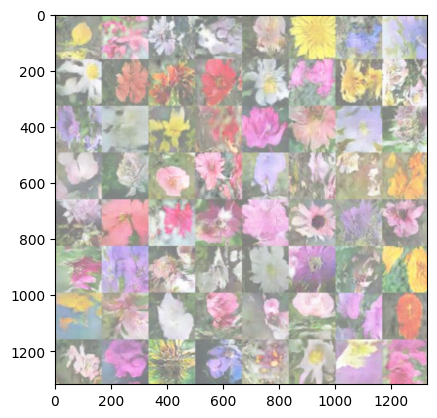

In [70]:
image = plt.imread("319210186_902609240731653_2122270037341232288_n.png")
plt.imshow(image)

### improved WGAN with "3rd pair and BERT"
之後，我們加入了BERT，也修改了loss的算法，加入了第三個pair。
將不同epoch的圖片呈現如下，可以發現這次就真的有學到text了。

不過，最終分數卻沒有比未優化的版本高，我想是因為我們train的epoch還不夠多，所以呈現出來的圖片品質還不夠好。

epoch:100


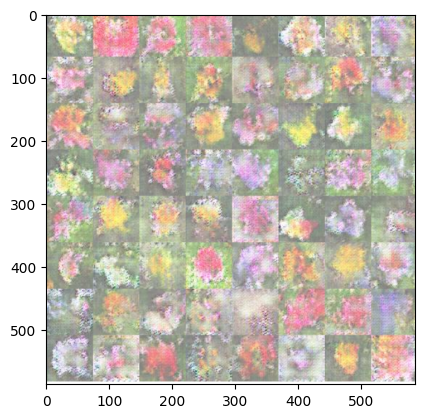

epoch:400


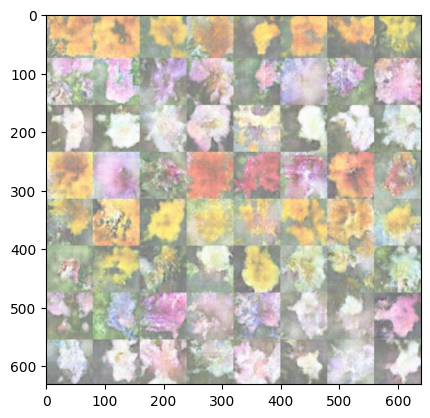

epoch:800


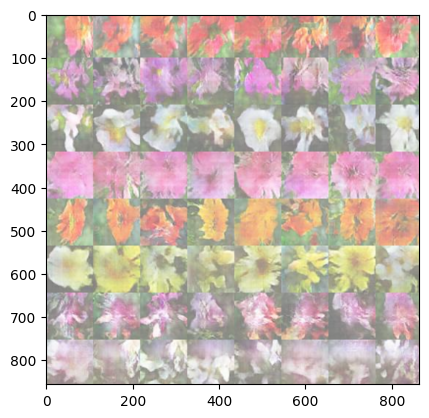

In [73]:
print("epoch:100")
image = plt.imread("320390088_719045642712569_6553334425431985761_n.png")
plt.imshow(image)
plt.show()
print("epoch:400")
image = plt.imread("319066916_1160095808207139_3818734317308985616_n.png")
plt.imshow(image)
plt.show()
print("epoch:800")
image = plt.imread("319909598_465040865803085_1750117505661270291_n.png")
plt.imshow(image)
plt.show()

In [34]:
def testing_data_generator(caption, index):
    caption = tf.cast(caption, tf.float32)
    return caption, index

def testing_dataset_generator(batch_size, data_generator):
    data = pd.read_pickle('./dataset/testData.pkl')
    captions = data['Captions'].values
    caption = []
    for i in range(len(captions)):
        caption.append(captions[i])
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    index = data['ID'].values
    index = np.asarray(index)
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, index))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat().batch(batch_size)
    
    return dataset

In [74]:
testing_dataset = testing_dataset_generator(hparas['BATCH_SIZE'], testing_data_generator)

In [75]:
data = pd.read_pickle('./dataset/testData.pkl')
captions = data['Captions'].values

NUM_TEST = len(captions)
EPOCH_TEST = int(NUM_TEST / hparas['BATCH_SIZE'])

In [78]:
def inference(dataset):
#     hidden = text_encoder.initialize_hidden_state()
    sample_size = hparas['BATCH_SIZE']
    sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
    
    step = 0
    start = time.time()
    for captions, idx in dataset:
        if step > EPOCH_TEST:
            break
        
        fake_image = test_step(captions, sample_seed)
        step += 1
        for i in range(hparas['BATCH_SIZE']):
            img = np.array(fake_image[i])
            img = (img-img.min()) * (1/((img.max()-img.min())))
            plt.imsave('./inference/demo/inference_{:04d}.jpg'.format(idx[i]), img)
#             plt.imsave('./inference/demo/inference_{:04d}.jpg'.format(idx[i]), fake_image[i].numpy()*0.5 + 0.5)
            
    print('Time for inference is {:.4f} sec'.format(time.time()-start))

In [79]:
def visualize(idx):
    fig = plt.figure(figsize=(14, 14))
    
    for count, i in enumerate(idx):
        loc = np.where(i==index)[0][0]
        text = ''
        for word in captions[loc]:
            if id2word_dict[word] != '<PAD>':
                text += id2word_dict[word]
                text += ' '
        print(text)
        
        path = './inference/demo/inference_{:04d}.jpg'.format(i)
        fake_image = plt.imread(path)
        
        plt.subplot(7, 7, count+1)
        plt.imshow(fake_image)
#         print(fake_image.max(), fake_image.min())
        plt.axis('off')

In [81]:
generator.load_weights("models/W_generator_bert.h5")
inference(testing_dataset)
data = pd.read_pickle('./dataset/testData.pkl')
captions = data['Captions'].values
index = data['ID'].values
random_idx = [23, 216, 224, 413, 713, 859, 876, 974, 1177, 1179, 1241, 2169, 2196, 2237, 
              2356, 2611, 2621, 2786, 2951, 2962, 3145, 3255, 3327, 3639, 3654, 3927, 4262, 
              4321, 4517, 5067, 5147, 5955, 6167, 6216, 6410, 6413, 6579, 6584, 6804, 6988, 
              7049, 7160]

visualize(random_idx)

In [ ]:
# csv = pd.read_csv("score_demo.csv")
# score = csv["score"]
# print(np.mean(score))